## Project Three: Three Body System

### New to this version

    1. The run_odeint seems to feed the velocity of the planet before the collision to the slope function despite a new definition of the velocity when nevermores2 first becomes True. The edited slope function solves(maybe) the problem by applying the same definition of the velocity as when nevermores2 first comes True. The animation of the orbit makes sense, although it is hard to validate with physics without knowing what odeint is doing.

    2. Basic two-planet model that does not account for collision

Initial Condition
    1. Two Stationary Stars and One Body Introduced
        init_state: Star1_p = (-100, 0) v = (0, 0)
                    Star2_p = (100, 0)  v = (0, 0)
                    Planet_p = (50, 50) v = (0, -50) 
                    
        
    2. Two Stationary Stars and Two Bodies Introduced with pretty much the same condition(chaos)
    
    3. Binary Star System with Two Bodies Introduced
    
    Mass of Sun: 2 * 10^30 kg (2 kg)
    Mass of Earth: 6 * 10^24 kg (.02kg)
    G constant: 6.67*10^-11
    
   
    binary star orbits: https://en.wikipedia.org/wiki/Habitability_of_binary_star_systems
    wired article: https://www.wired.com/2016/06/way-solve-three-body-problem/
    

In [1]:
%matplotlib notebook
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

In [28]:
condition = Condition(#m_s1 = 2,
                      m_s1 = 2 * 10**9,
                      m_s2 = 2 * 10**9,
                      m_p1 = 6 * 10**3,
                      G = 6.67*10**-5,
                      duration = 2500,
                    #Minimun dt needed for accuracy varies depending on duration
                      dt = 0.001)

In [29]:
def make_system(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-70)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, ts=ts, dt = dt, m_pnew = 0,
                  nevermores1 = 0, nevermores2 = 0)

In [17]:
system = make_system(condition)

In [ ]:
def slope_func_1(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    distance_p1s1 = pos_s1 - pos_p1
    distance_p1s2 = pos_s2 - pos_p1
    
    F_p1s1 = (G * m_s1 * m_p1 / (distance_p1s1.mag**2)) * distance_p1s1.hat()
    F_p1s2 = (G * m_s2 * m_p1 / (distance_p1s2.mag**2)) * distance_p1s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / m_p1
    v_p1 = Vector(v_p1)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [ ]:
slope_func_1(system.init, 0, system)

In [ ]:
def slope_func_inelastic(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    m_pnew = system.m_pnew
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    #print('A', v_p1)
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (10**2) and nevermores1 == 0:
        print("collision between planet and sun1")
        distance_p1s1 = pos_s1 - pos_s1 #zero vector
        system.nevermores1 = 1
        m_pnew += m_s1
        system.m_pnew += m_s1
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_pnew))
        print(distance_p1s1)
        F_p1s1 = Vector(0,0)
        
    else:
        distance_p1s1 = pos_s1 - pos_p1
        F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (10**2) and nevermores2 == 0:
        print("collision between planet and sun2")
        system.nevermores2 = 1
        m_pnew += m_s2
        system.m_pnew += m_s2
        v_p1 = v_p1 * (m_p1 / (m_p1 + m_pnew))
        #print(v_p1)
        F_p1s2 = Vector(0,0)
        
    else:
        if nevermores2 == 0:
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
        else:
            v_p1 = v_p1 * (m_p1 / (m_p1 + m_s2))
            F_p1s2 = Vector(0,0)
            #print()
    
    a_p1s1 = F_p1s1 / (m_p1 + m_pnew)
    a_p1s2 = F_p1s2 / (m_p1 + m_pnew)
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * (m_p1 + m_pnew)
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / (m_p1 + m_pnew)
    v_p1 = Vector(v_p1)
    
    #print(t, v_p1, pos_p1, m_pnew, a)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [30]:
def slope_func_coll(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1 = state
    unpack(system)
    m_pnew = system.m_pnew
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    coll = 0
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    #print('A', v_p1)
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (20**2):
        if nevermores1 == 0:
            print("collision between planet and sun1")
            system.nevermores1 = 1
        coll = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll == 0):
            system.nevermores1 = 0
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (20**2):
        if nevermores2 == 0:
            print("collision between planet and sun2")
            system.nevermores2 = 1
        coll = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll == 0):
            system.nevermores2 = 0
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
    
    a_p1s1 = F_p1s1 / (m_p1 + m_pnew)
    a_p1s2 = F_p1s2 / (m_p1 + m_pnew)
    a = a_p1s1 + a_p1s2
    #print(a)
    a = Vector(a)
    #print(type(a))
    
    p_present = v_p1 * (m_p1 + m_pnew)
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total = p_present+p_p1s1+p_p1s2
    
    v_p1 = p_total / (m_p1 + m_pnew)
    v_p1 = Vector(v_p1)
    
    #print(t, v_p1, pos_p1, m_pnew, a)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, 0, 0, 0, 0, a.x, a.y

In [31]:
slope_func_coll(system.init, 0, system)

(0,
 0,
 0,
 0,
 <Quantity(1380.3434843659545, 'dimensionless')>,
 <Quantity(-2125.300028152293, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(1380343.4843659543, 'dimensionless')>,
 <Quantity(-2055300.028152293, 'dimensionless')>)

In [ ]:
system = make_system(condition)

%time run_odeint(system, slope_func_inelastic)

In [32]:
system = make_system(condition)

%time run_odeint(system, slope_func_coll)

collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision between planet and sun2
collision betw

collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision betw

collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision between planet and sun1
collision betw

<IPython.core.display.Javascript object>


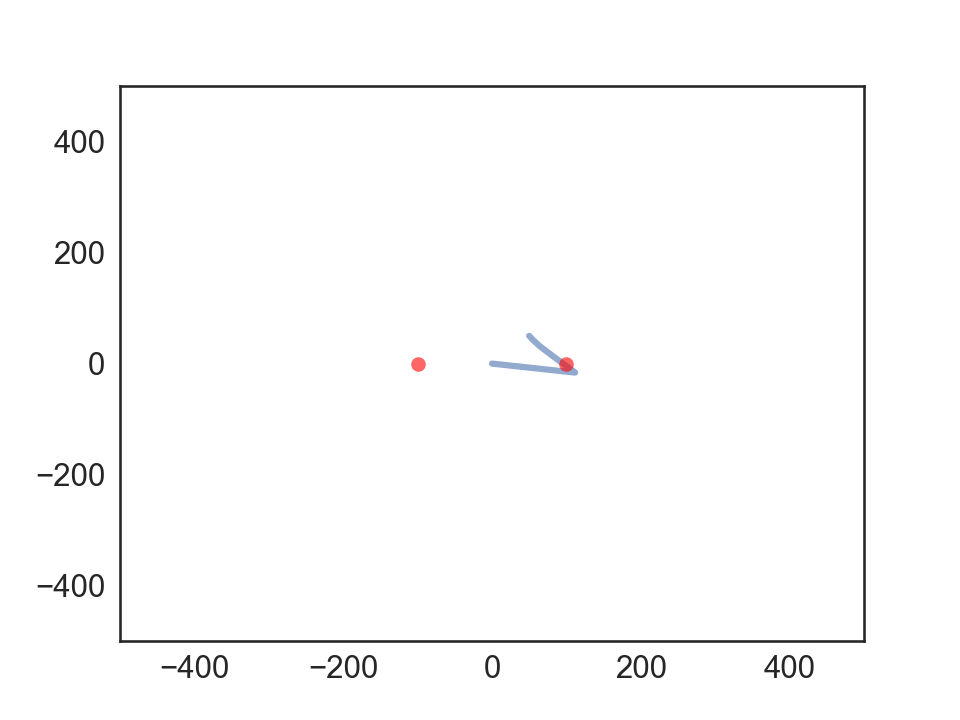

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [25]:
newfig()
plot(system.results.x_p1, system.results.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


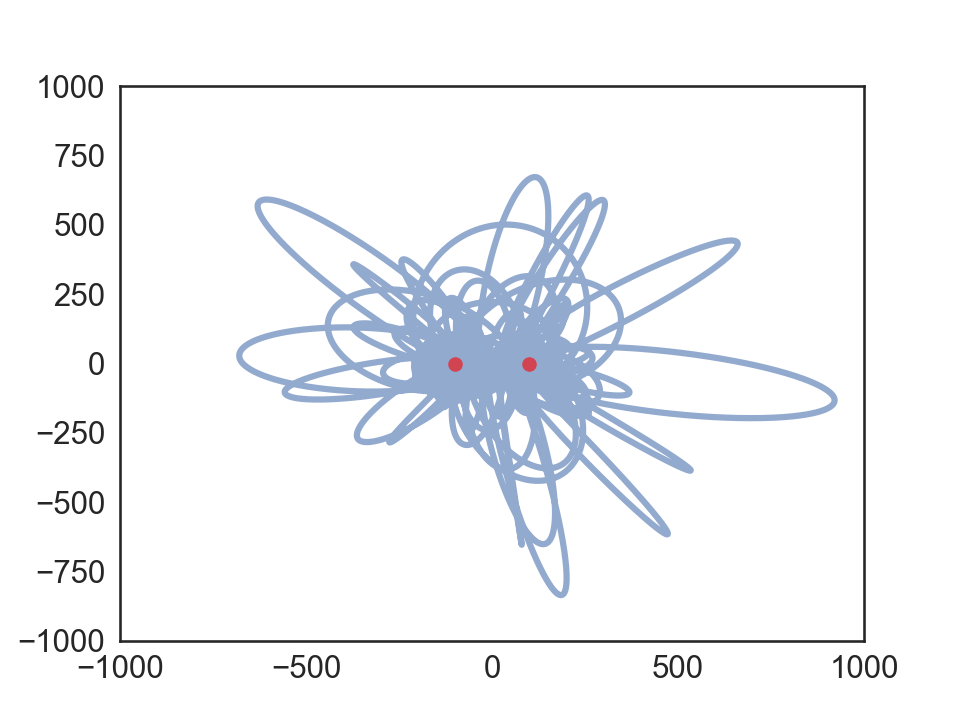

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [33]:
resampled = system.results.iloc[::500, :]
newfig()
plot(resampled.x_p1, resampled.y_p1)
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-1000, 1000],
         ylim = [-1000, 1000])

<IPython.core.display.Javascript object>


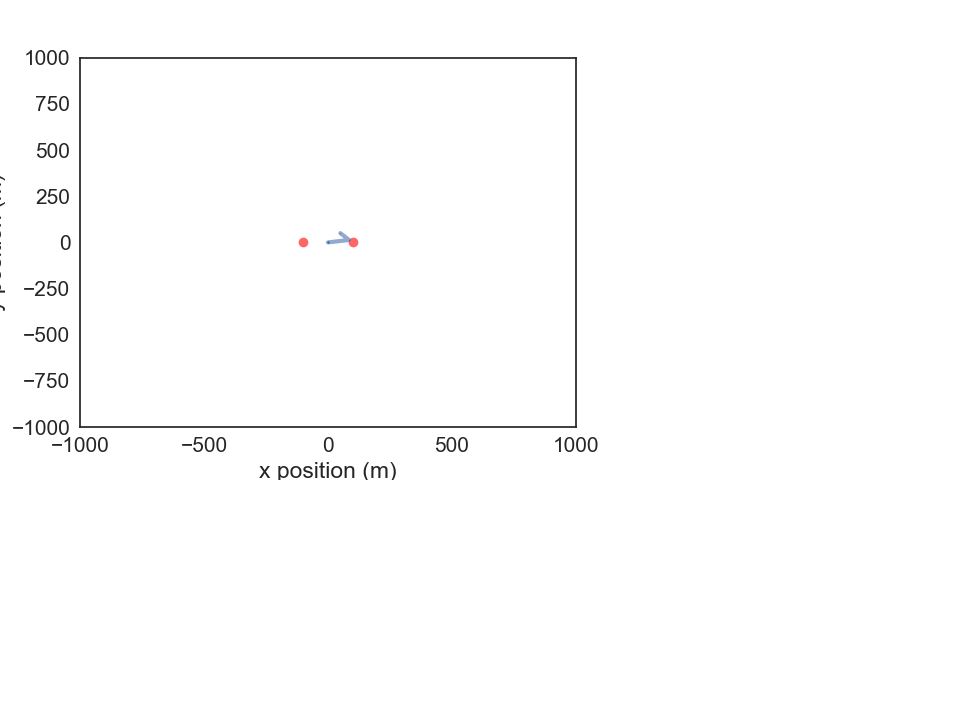

KeyboardInterrupt: 

In [14]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-1000, 1000],
         ylim =[-1000, 1000],
         legend=False)
x_array = []
y_array = []
for x, y in zip(resampled.x_p1, resampled.y_p1):
    x_array.append(x)
    y_array.append(y)
    plot(x_array, y_array, '-o', markersize=1, update=True)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)

## Two Planets

In [48]:
condition_2planets = Condition(m_s1 = 2 * 10**9,
                      m_s2 = 2 * 10**9,
                      m_p1 = 6 * 10**3,
                      m_p2 = 6 * 10**3,
                      G = 6.67*10**-5,
                      duration = 2500,
                    #Minimun dt needed for accuracy varies depending on duration
                      dt = 0.0001)

In [49]:
def make_system_2planets(condition):
    """Make a system object.
    
    condition: Condition object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(condition)
    
    # make the initial state
    init = State(x_s1=-100, y_s1=0, x_s2=100, y_s2=0, x_p1=50, y_p1=50, x_p2=50, y_p2=51,
                 vx_s1=0, vy_s1=0, vx_s2=0, vy_s2=0, vx_p1=0, vy_p1=-65, vx_p2=0, vy_p2=-65)
    
    # compute timestamps
    ts = linrange(0, duration, dt)
    
    return System(init=init, G = G, m_s1 = m_s1, m_s2 = m_s2, m_p1 = m_p1, m_p2 = m_p2, ts=ts, dt = dt, m_pnew = 0,
                  nevermores1 = 0, nevermores2 = 0, nevermores3 = 0, nevermores4 = 0, metric = 0, found_metric = 0, posp1 = [], posp2 = [])

In [59]:
def slope_func_2(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
 n  m    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    x_s1, y_s1, x_s2, y_s2, x_p1, y_p1, x_p2, y_p2, vx_s1, vy_s1, vx_s2, vy_s2, vx_p1, vy_p1, vx_p2, vy_p2 = state
    unpack(system)
    
    nevermores1 = system.nevermores1
    nevermores2 = system.nevermores2
    nevermores3 = system.nevermores3
    nevermores4 = system.nevermores4
    coll1 = 0
    coll2 = 0
    
    pos_p1 = Vector(x_p1, y_p1)
    v_p1 = Vector(vx_p1, vy_p1)
    pos_p2 = Vector(x_p2, y_p2)
    v_p2 = Vector(vx_p2, vy_p2)
    pos_s1 = Vector(x_s1, y_s1)
    pos_s2 = Vector(x_s2, y_s2)
    
    system.posp1.append(pos_p1)
    system.posp2.append(pos_p2)
    
    if system.found_metric == 0:
        if pos_p1.dist(pos_p2) > 15:
            if abs(pos_p1.diff_angle(pos_p2)) > 0.1745329252: #10 degrees
                dis1 = []
                dis2 = []
                for p1, p2 in zip(system.posp1, system.posp2):
                    dis1.append(pos_p1.dist(p2))
                    dis2.append(pos_p2.dist(p1))
                min_dis1 = sorted(dis1)[0]
                min_dis2 = sorted(dis2)[0]
                if (min_dis1 > 15 and min_dis2 > 15):
                    print("diverged")
                    system.found_metric = 1
                    system.metric = t
    
    if ((x_p1 - x_s1)**2 + (y_p1 - y_s1)**2) < (20**2): 
        if nevermores1 == 0:
            print("collision between p1 and sun1")
            system.nevermores1 = 1
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores1 = 0
            distance_p1s1 = pos_s1 - pos_p1
            F_p1s1 = (G * m_s1 * (m_p1 + m_pnew) / (distance_p1s1.mag**2)) * distance_p1s1.hat()
        

    if ((x_p1 - x_s2)**2 + (y_p1 - y_s2)**2) < (20**2):
        if nevermores2 == 0:
            print("collision between p1 and sun2")
            system.nevermores2 = 1
        coll1 = 1
        F_p1s1 = Vector(0,0)
        F_p1s2 = Vector(0,0)
        
    else:
        if (coll1 == 0):
            system.nevermores2 = 0
            distance_p1s2 = pos_s2 - pos_p1
            F_p1s2 = (G * m_s2 * (m_p1 + m_pnew) / (distance_p1s2.mag**2)) * distance_p1s2.hat()
            
    if ((x_p2 - x_s1)**2 + (y_p2 - y_s1)**2) < (20**2): 
        if nevermores3 == 0:
            print("collision between p2 and sun1")
            system.nevermores3 = 1
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores3 = 0
            distance_p2s1 = pos_s1 - pos_p2
            F_p2s1 = (G * m_s1 * (m_p2 + m_pnew) / (distance_p2s1.mag**2)) * distance_p2s1.hat()
            
    if ((x_p2 - x_s2)**2 + (y_p2 - y_s2)**2) < (20**2): 
        if nevermores4 == 0:
            print("collision between p2 and sun2")
            system.nevermores4 = 1
        coll2 = 1
        F_p2s1 = Vector(0,0)
        F_p2s2 = Vector(0,0)
        
    else:
        if (coll2 == 0):
            system.nevermores4 = 0
            distance_p2s2 = pos_s2 - pos_p2
            F_p2s2 = (G * m_s2 * (m_p2 + m_pnew) / (distance_p2s2.mag**2)) * distance_p2s2.hat()
            
#     distance_p1s1 = pos_s1 - pos_p1
#     distance_p1s2 = pos_s2 - pos_p1
#     distance_p2s1 = pos_s1 - pos_p2
#     distance_p2s2 = pos_s2 - pos_p2
    
#     F_p1s1 = (G * m_s1 * m_p1 / (distance_p1s1.mag**2)) * distance_p1s1.hat()
#     F_p1s2 = (G * m_s2 * m_p1 / (distance_p1s2.mag**2)) * distance_p1s2.hat()
#     F_p2s1 = (G * m_s1 * m_p2 / (distance_p2s1.mag**2)) * distance_p2s1.hat()
#     F_p2s2 = (G * m_s2 * m_p2 / (distance_p2s2.mag**2)) * distance_p2s2.hat()
    
    a_p1s1 = F_p1s1 / m_p1
    a_p1s2 = F_p1s2 / m_p1
    a_p1 = a_p1s1 + a_p1s2
    a_p1 = Vector(a_p1)

    a_p2s1 = F_p2s1 / m_p2
    a_p2s2 = F_p2s2 / m_p2
    a_p2 = a_p2s1 + a_p2s2
    a_p2 = Vector(a_p2)
    
    p_present_p1 = v_p1 * m_p1
    p_p1s1 = F_p1s1 * dt
    p_p1s2 = F_p1s2 * dt
    p_total_p1 = p_present_p1+p_p1s1+p_p1s2
    
    p_present_p2 = v_p2 * m_p1
    p_p2s1 = F_p2s1 * dt
    p_p2s2 = F_p2s2 * dt
    p_total_p2 = p_present_p2+p_p2s1+p_p2s2
    
    v_p1 = p_total_p1 / m_p1
    v_p1 = Vector(v_p1)
    v_p2 = p_total_p2 / m_p2
    v_p2 = Vector(v_p2)
    
    #Use positions to find force acting on the planet, use the force to find momentum and acceleration, and then 
    #velocity from momentum. Return velocity and acceleration.
    
    return 0, 0, 0, 0, v_p1.x, v_p1.y, v_p2.x, v_p2.y, 0, 0, 0, 0, a_p1.x, a_p1.y, a_p2.x, a_p2.y

In [60]:
system_2planet = make_system_2planets(condition_2planets)
slope_func_2(system_2planet.init, 0, system_2planet)

(0,
 0,
 0,
 0,
 <Quantity(0.0013803434843659547, 'dimensionless')>,
 <Quantity(-65.00205530002815, 'dimensionless')>,
 <Quantity(0.001327643049304156, 'dimensionless')>,
 <Quantity(-65.0020385005135, 'dimensionless')>,
 0,
 0,
 0,
 0,
 <Quantity(13.803434843659547, 'dimensionless')>,
 <Quantity(-20.553000281522934, 'dimensionless')>,
 <Quantity(13.276430493041556, 'dimensionless')>,
 <Quantity(-20.38500513517885, 'dimensionless')>)

In [61]:
system_2planet = make_system_2planets(condition_2planets)
run_odeint(system_2planet, slope_func_2)

diverged
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p2 and sun1
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
c

collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p2 and sun2
collision between p1 and sun1
collision between p1 and sun1
collision 

collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun1
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision between p1 and sun2
collision 

In [ ]:
newfig()
plot(system_2planet.results.x_p1, system_2planet.results.y_p1, 'r--', label = 'planet1')
plot(system_2planet.results.x_p2, system_2planet.results.y_p2, 'b:', label = 'planet2')
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500],
         legend = True)

In [62]:
print(system_2planet.metric)

94.91917392067137


In [56]:
print(system_2planet.results.index)

Float64Index([      0.0,    0.0001,    0.0002,    0.0003,    0.0004,    0.0005,
                 0.0006,    0.0007,    0.0008,    0.0009,
              ...
              2499.9991, 2499.9992, 2499.9993, 2499.9994, 2499.9995, 2499.9996,
              2499.9997, 2499.9998, 2499.9999,    2500.0],
             dtype='float64', length=25000001)


<IPython.core.display.Javascript object>


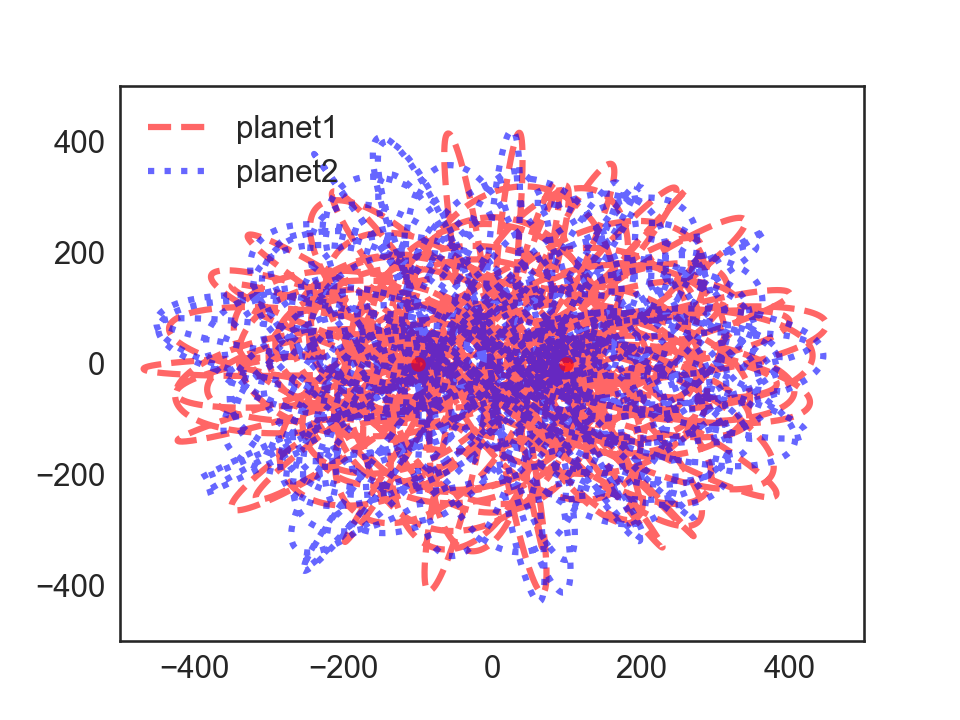

In [63]:
resampled_2planet = system_2planet.results.iloc[::1000, :]
newfig()
plot(resampled_2planet.x_p1, resampled_2planet.y_p1, 'r--', label = 'planet1')
plot(resampled_2planet.x_p2, resampled_2planet.y_p2, 'b:', label = 'planet2')
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlim = [-500, 500],
         ylim = [-500, 500])

<IPython.core.display.Javascript object>


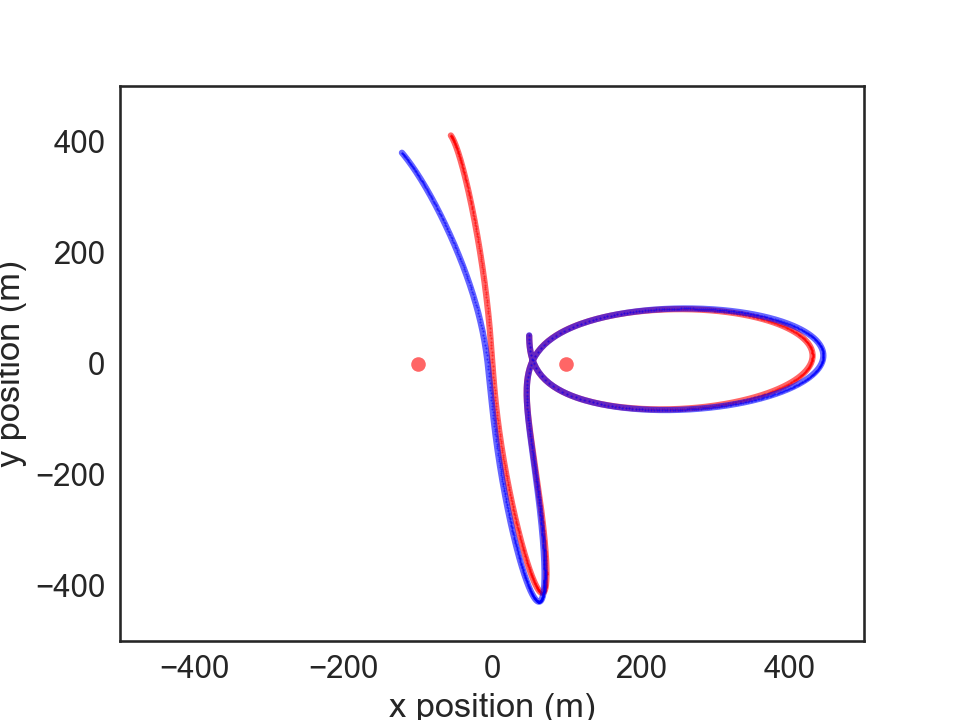

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit

In [64]:
newfig()
plot(-100, 0, 'ro')
plot(100, 0, 'ro')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
         xlim = [-500, 500],
         ylim =[-500, 500],
         legend=False)
x1_array = []
y1_array = []
x2_array = []
y2_array = []
for x1, y1, x2, y2, index in zip(resampled_2planet.x_p1, resampled_2planet.y_p1, resampled_2planet.x_p2, resampled_2planet.y_p2, resampled_2planet.index):
    if index > system_2planet.metric:
        print("diverge")
        break
    x1_array.append(x1)
    y1_array.append(y1)
    x2_array.append(x2)
    y2_array.append(y2)
    plot(x1_array, y1_array, '-ro', markersize=1, update=True)
    plot(x2_array, y2_array, '-bo', markersize=1, update=True)
    #plot(x, y, '-o', update=True)
    #sleep(0.00001)